In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# Using autoreload to reload modules. Helps in debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
"""
Functions written for ease of usage of the model.
"""

def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature = pd.DataFrame(df[feature_names[:]])
    df_target = pd.DataFrame(df[target_names[:]])
    return df_feature, df_target

def plot_data(df: pd.DataFrame, 
              feature: str, 
              target: str):
    sns.set()
    feature = pd.DataFrame(df[feature])
    target = pd.DataFrame(df[target])
    plt.scatter(feature, target)

# Finds xy correlation constant
def calc_correlation(df: pd.DataFrame,
                     feature: str,
                     target: str):
    f = df[feature].to_numpy()
    t = df[target].to_numpy()
    coef = np.corrcoef(f, t)[0][1]
    if np.isnan(coef):
        return 0
    return coef

def get_numpy_features(df: pd.DataFrame,
                       feature_names: list[str],
                       target_names: list[str]):
    f_n = df[feature_names[:]].to_numpy()
    t_n = df[target_names[:]].to_numpy()
    return f_n, t_n

In [ ]:
"""
Getting Data from data.csv.
"""

# Sanity check: stops program if the number of datapoints differ across columns
try:
    df: pd.DataFrame = pd.read_csv("../data/data.csv")
    if (len(set(df.count())) != 1):
        raise Exception("Datapoints differ across columns")
except Exception as e:
    print(f"Caught: {e}")

# Independant Variable
VAR_Y = 'YEAR'
VAR_C = 'CROP_YIELD_BPA'
VAR_CU = 'CROP_YIELD_USA_BPA'

# Dependant Variables

VAR_TEMP = 'TEMP_F'
VAR_RAIN = 'RAINFALL_IN'
VAR_WIND = 'WINDSPEED_MPH'
VAR_SNOW = 'SNOWFALL_IN'
VAR_PEST = 'PESTICIDE_M_TON'
VAR_GDP = 'GDP_$'
VAR_FERT = 'FERTILISER_M_TON'

vars = [VAR_TEMP, VAR_RAIN, VAR_WIND, VAR_SNOW, VAR_PEST, VAR_GDP, VAR_FERT]

df_features, df_target = get_features_targets(df, 
                                              vars, 
                                              [VAR_CU])

# The Data

The below code demonstrates how we chose which independent variables we used in our final model. Each independent variable correlates with the dependent variable to some degree. This degree is measured by the coefficient of correlation `(r)`.

To easily visualize this correlation, we have included graphs depicting the depdendant variable (Crop Yield in Buschels/Acre) and how it varies with each of the seven indepdendent variables we found data on.

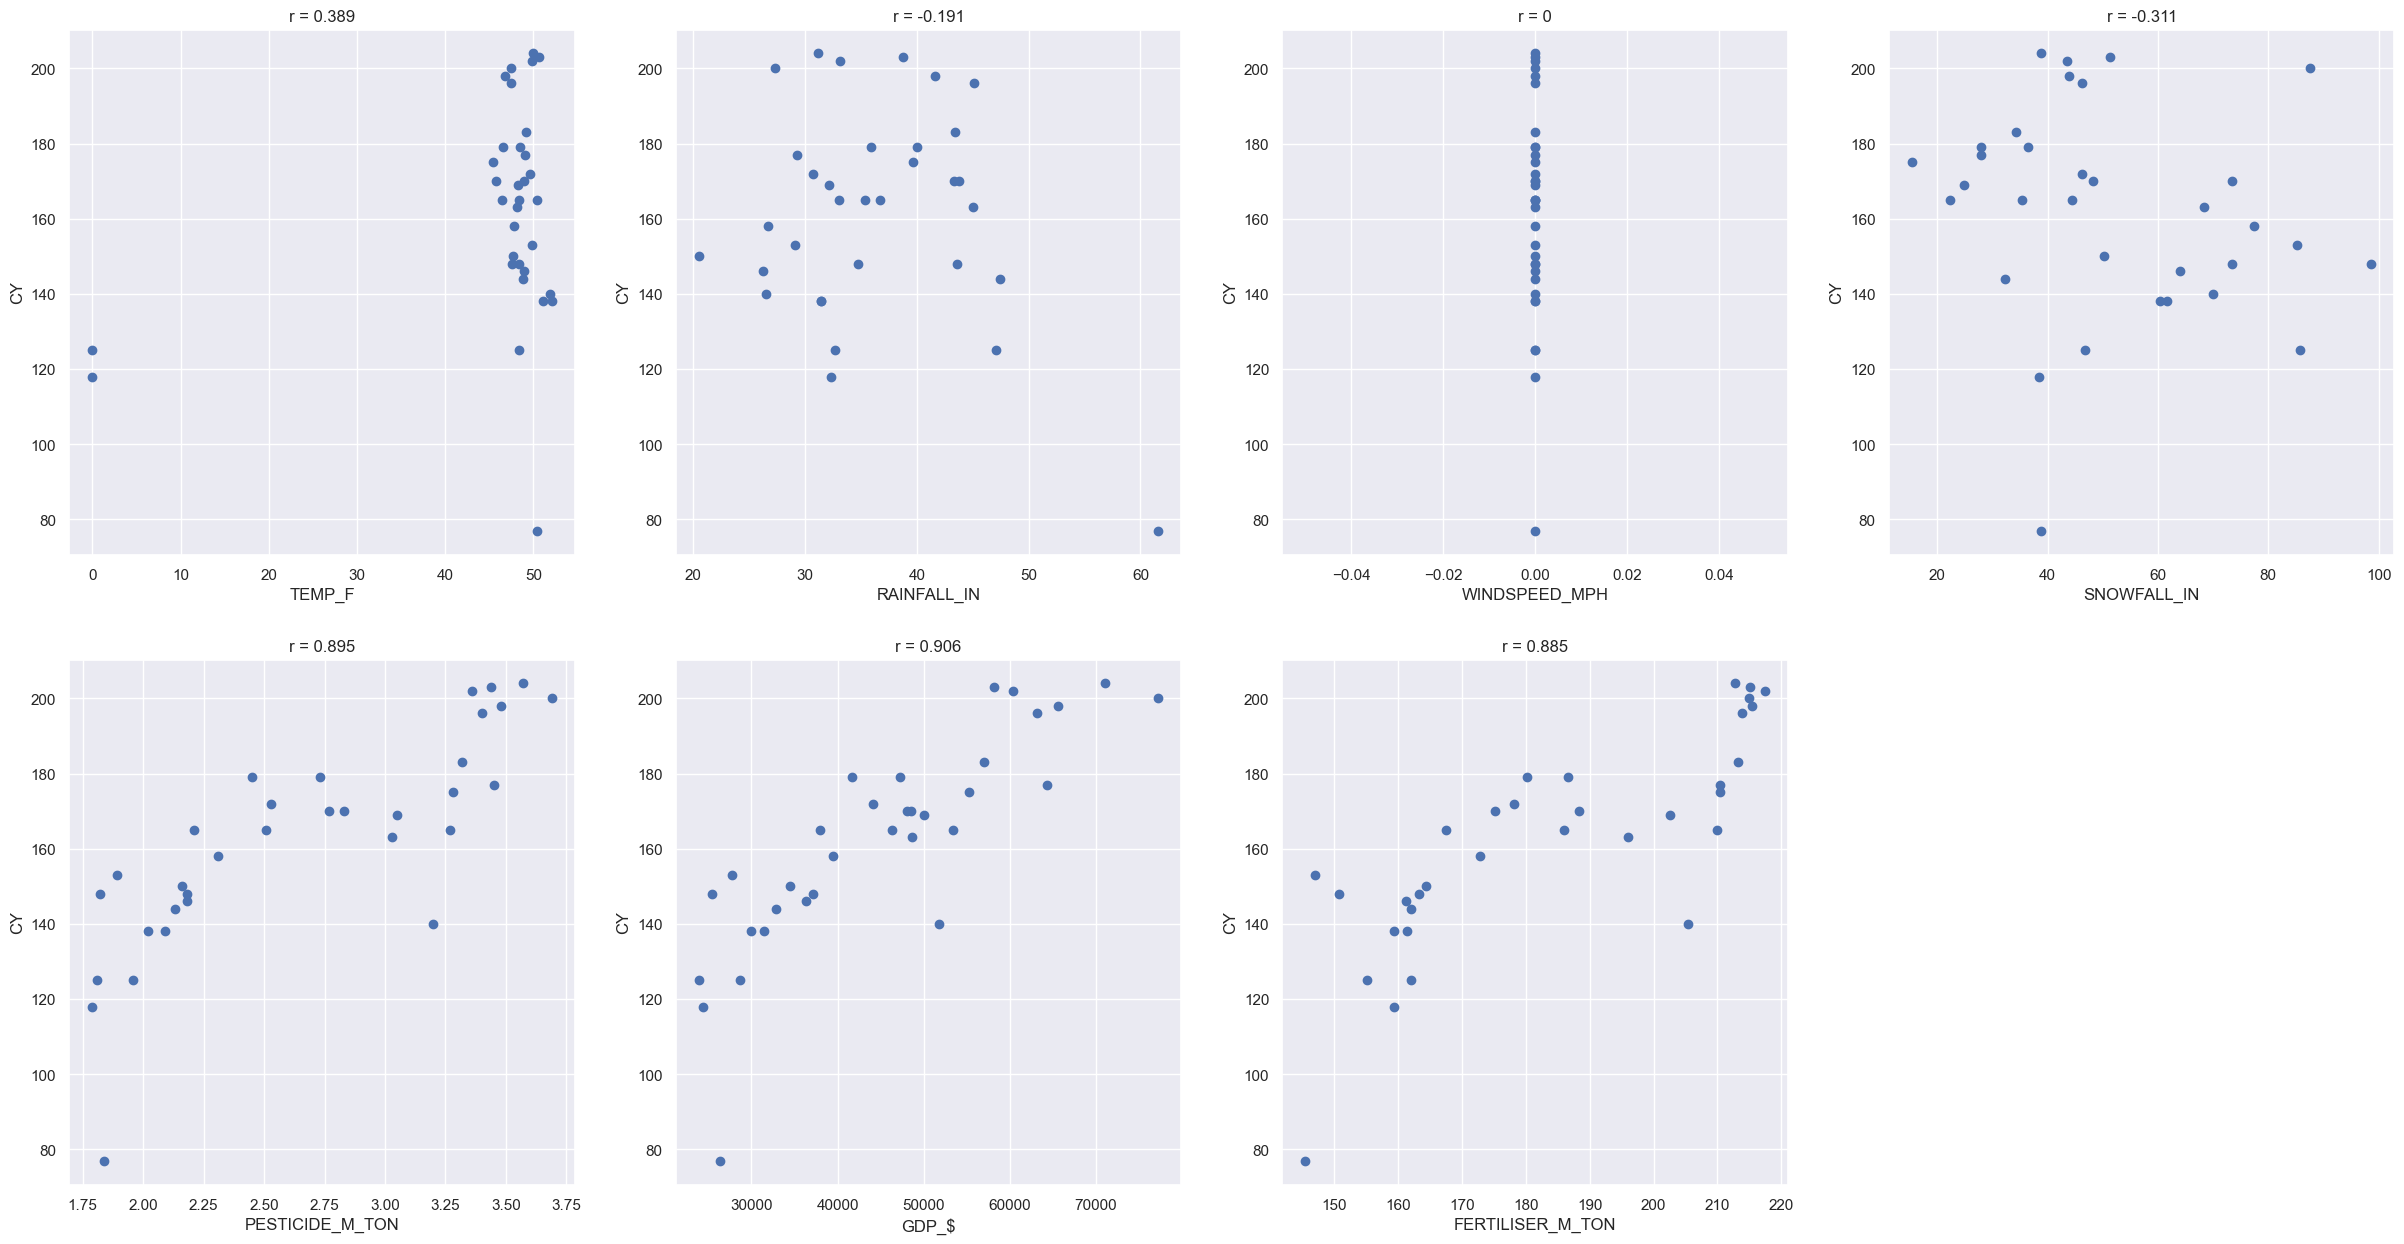

In [ ]:
"""
Relationship between each dependant and independant variable

"""
plt.figure(figsize=(30, 15))

i = 1
for var in vars:
    plt.subplot(2, 4, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/correlation.png")
# plot_data(df, dep[VAR_PEST], VAR_C)

Correlation changes as follows:
1. r > 0: Positive Correlation
2. r = 0: No Correlation
3. r < 0: Negative Correlation
4. r = 1: Linear Positive Correlation
5. r = -1: Linear Negative Correlation

Therefore, we chose independent variables which corresponded with a large |r| value. For a better model, we decided to use 3 independent variables.

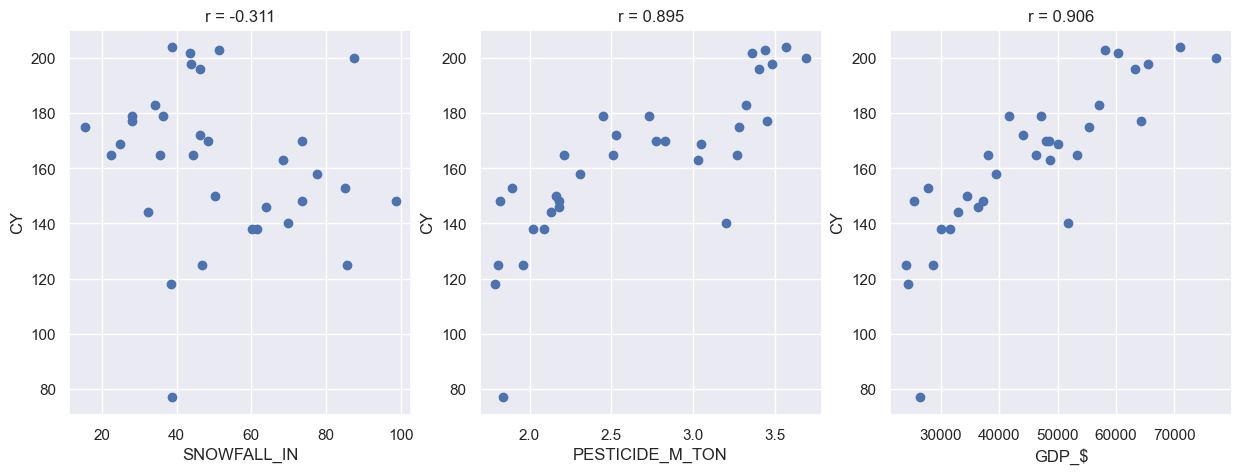

In [6]:

VAR_SNOW: 'SNOWFALL_IN'
VAR_PEST: 'PESTICIDE_M_TON'
VAR_GDP: 'GDP_$'

chosen_dep = [VAR_SNOW, VAR_PEST, VAR_GDP]

plt.figure(figsize=(15, 5))

i = 1
for var in chosen_dep:
    plt.subplot(1, 3, i)
    plt.xlabel(var)
    plt.ylabel("CY")
    r = calc_correlation(df, var, VAR_CU)
    plt.title(f"r = {round(r, 3)}")
    plot_data(df, var, VAR_C)
    i += 1

plt.savefig("../data/figures/chosendep.png")

# The Model

We defined the class MVF to represent our model. The class is stored in [regresion_functions.py](regression_functions.py). It contains the following properties:

1. `ind`: Represents a matrix of independent variables
2. `dep`: Represents a matrix of dependent variables
3. `weights`: initialized to an empty array. Represents a matrix of the weights produced by the model.
4. `costs`: Represents the result of the cost function. Used to improve the model after calculating costs.

We use the following methods:

```
def normalize_array(array):
    mean = array.mean(axis=0)
    std = array.std(axis=0)
    return (array - mean) / std, mean, std
```

The function returns a normalized array, which allows us to run our model without overflow. 

```
def normalize_data(self):
    self.ind, self.ind_mean, self.ind_std = normalize_array(self.ind)
    self.dep, self.dep_mean, self.dep_std = normalize_array(self.dep)
```

The values of the mean and standard deviation are stored so that the data can be later visualized in its original scale.

```
class MVF:

    # ind: independant variable matrix, np array, size = no. of data points * no. of dependant variables
    # dep: depdendant variable matrix, size = no. of data points * 1

    def __init__(self, ind, dep):
    
        self.lr = 0.01
        self.iterations = 1000
        self.ind = ind
        self.dep = dep
        self.ind_mean, self.ind_std, self.dep_mean, self.dep_std = None, None, None, None

        self.weights = np.zeros((self.ind.shape[1], 1))
        
        self.feature_names = []
        self.target_names = None
    
        self.costs = []
        self.predictions = None
```

```
def gradient_descent(self, lambda_reg=0.1, tol=1e-6):
    ind = np.c_[np.ones(self.ind.shape[0]), self.ind]
    weights = np.zeros((ind.shape[1], 1))
    m = len(self.dep)
    
    for _ in range(self.iterations):
        predictions = np.dot(ind, weights)
        errors = predictions - self.dep
        gradient = (1 / m) * np.dot(ind.T, errors)
        weights -= self.lr * gradient
        cost = self._compute_cost(ind, weights)
        self.costs.append(cost)

        if len(self.costs) > 1 and abs(costs[-1] - costs[-2]) < tol: 
            print("Convergence found")
            break

    self.weights = weights
    self.predictions = predictions * self.dep_std + self.dep_mean
```

The function runs the gradient descent method on our independent variables and updates the weights every iteration. The number of iterations is fixed to 1000. The learning rate is also fixed to 0.01. The gradient descent function is very sensitive to the learning rate. 

The below code gathers the target and features from the dataframe and initializes a model with them. The data is then normalized, and the gradient descent algorithm is complete. The matrix below the cell represents the weights.

In [7]:

# Data transformation
from regression_functions import MVF
f, t = get_numpy_features(df, ['SNOWFALL_IN', 'PESTICIDE_M_TON', 'GDP_$'], [VAR_CU])
model = MVF(f, t)
model.feature_names = ['SNOWFALL_IN', 'PESTICIDE_M_TON', 'GDP_$']
model.target_name = VAR_CU
model.normalize_data()
model.gradient_descent()
print(model.weights[1:4])
# print(model.costs)
# print(model.predictions)

[[-0.08994607]
 [ 0.37866315]
 [ 0.51020136]]


# Visualizing the Model

Since we used 3 independent variables, it is impossible to visualize the 4-dimensional model. We chose to write a function that keeps one of the independent variables constant and plot the regression plane based on how the other two variables vary. 

The results are saved under [data/figures](../data/figures/).

In [17]:
def plot_with_two_varied_variables(model: MVF, feature_to_keep_constant, constant_value=None, savefig=None):
    """
    Visualizes the data by varying two features and keeping one feature constant.

    Parameters:
    X (numpy.ndarray): Feature matrix, including the bias term as the first column.
    y (numpy.ndarray): Actual target values.
    weights (numpy.ndarray): Weights of the regression model, including the bias term.
    features_to_vary (tuple): Indices of the two features to vary.
    feature_to_keep_constant (int): Index of the feature to keep constant.
    constant_value (float): Value to keep the constant feature at.
    X_mean (numpy.ndarray): Mean of the features before normalization.
    X_std (numpy.ndarray): Standard deviation of the features before normalization.
    y_mean (float): Mean of the target variable before normalization.
    y_std (float): Standard deviation of the target variable before normalization.
    """

    X = model.get_ind
    y = model.get_dep
    weights = model.weights

    assert feature_to_keep_constant < X.shape[1], 'Invalid feature index'

    vfi = [i for i in range(X.shape[1]) if i != feature_to_keep_constant]
    print(vfi)
    feature1, feature2 = vfi[0], vfi[1]
    # print(model.feature_names[feature1], model.feature_names[feature2])

    X_mean, X_std = model.get_ind_mean_std
    y_mean, y_std = model.get_dep_mean_std

    # Generate ranges for the two features to vary (in normalized scale)
    x1_varied_norm = np.linspace(X[:, feature1].min(), X[:, feature1].max(), 50)
    x2_varied_norm = np.linspace(X[:, feature2].min(), X[:, feature2].max(), 50)

    # Create a meshgrid for the two features
    X1_norm, X2_norm = np.meshgrid(x1_varied_norm, x2_varied_norm)

    # Scale back the feature ranges to the original scale
    X1_orig = X1_norm * X_std[feature1] + X_mean[feature1]  # Exclude bias
    X2_orig = X2_norm * X_std[feature2] + X_mean[feature2]  # Exclude bias

    if constant_value is None:
        constant_value = X_mean[feature_to_keep_constant]

    # Create a copy of the feature matrix and set the constant feature to the given value
    X_copy = np.zeros((X1_norm.size, X.shape[1]))
    X_copy[:, 0] = 1  # Bias term
    X_copy[:, feature1] = X1_norm.ravel()
    X_copy[:, feature2] = X2_norm.ravel()
    X_copy[:, feature_to_keep_constant] = (constant_value - X_mean[feature_to_keep_constant]) / X_std[feature_to_keep_constant]

    # Compute predictions in normalized scale
    y_pred_normalized = np.dot(X_copy, weights[1:4])

    # Scale predictions back to original scale
    y_pred = y_pred_normalized * y_std + y_mean

    # Reshape predictions for plotting
    Y_pred = y_pred.reshape(X1_orig.shape)

    # Plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.clear()

    ax.plot_surface(X1_orig, X2_orig, Y_pred, cmap='viridis', alpha=0.8)
    ax.set_xlabel(f'{model.feature_names[feature1]} (Original Scale)')
    ax.set_ylabel(f'{model.feature_names[feature2]} (Original Scale)')
    ax.set_zlabel(f'{model.target_name} (Original Scale)')
    ax.set_box_aspect(None, zoom=0.95)
    plt.title(f'Constant Value: {model.feature_names[feature_to_keep_constant]} = {round(constant_value, 3)}')
    plt.show()

    if savefig:
        plt.savefig(savefig)
    
# plot_with_two_varied_variables(model, 1, constant_value=1)


[0, 2]


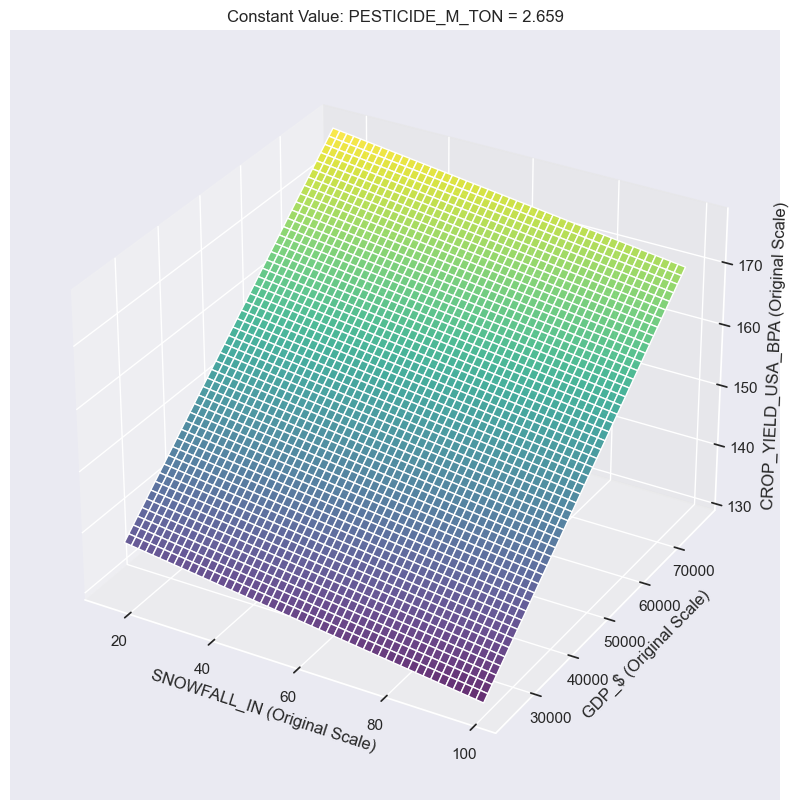

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
Change feature_to_keep_constant based on:

    0: SNOWFALL_IN
    1: PESTICIDE_M_TON
    2: GDP_$

"""

plot_with_two_varied_variables(model, feature_to_keep_constant=1, savefig="../data/figures/Constant_Pesticide.png")

# The Cost Function

The gradient of the cost function with respect to the weights gives the direction to adjust the weights and reduce the cost. The weights are updated in the opposite direction of the gradient in order to minimize the cost. If the cost function is converging, and the reduction in cost is negligible, the gradient_descent can end early. Hence the usage of the following code block in `gradient_descent()`.

```
if len(self.costs) > 1 and abs(costs[-1] - costs[-2]) < tol: 
    print("Convergence found")
    break
```

If the cost decreases too slowly, the learning rate can be tuned accordingly because gradient_descent is highly sensitive to the learning rate. Finally, we used L2 Regularization which increases/decreases the cost by a regularization term. This essentially adds penalties to prevent overfitting. 

The cost function is represented below along with the number of iterations. The convergence shows that the costs are low, and the model after 1000 iterations is relatively accurate.

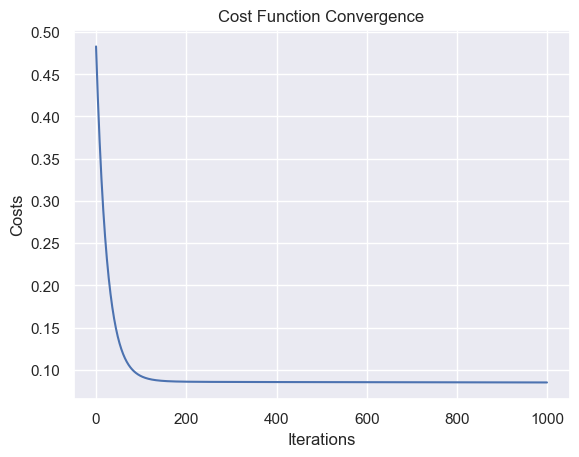

In [24]:
plt.plot(range(model.iterations), model.costs)
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.title('Cost Function Convergence')
plt.show()